In [6]:
import random

import gymnasium as gym
import numpy as np

import tensorflow as tf

from keras import Model
from keras.layers import Dense

In [7]:
class DQN(Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        self.replay_memory = []

        self.dense1 = Dense(128, activation="relu", input_dim=state_size)
        self.dense2 = Dense(128, activation="relu")
        self.dense3 = Dense(64, activation="relu")
        self.dense4 = Dense(32, activation="relu")
        self.dense5 = Dense(action_size, activation="softmax")

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)

        return x
    
    def remember(self, state, action, reward, next_state, done):
        self.replay_memory.append((state, action, reward, next_state, done))

In [23]:
def update_model(model: DQN):
    # 리플레이 버퍼 크기가 작으면 업데이트하지 않음
    if len(model.replay_memory) < 1000:
        return
    
    # 너무 많으면 리플레이 버퍼 pop
    if len(model.replay_memory) > 30000:
        del model.replay_memory[0]

    # # 메모리에서 랜덤 샘플링
    sample_size = 500
    samples = random.sample(model.replay_memory, sample_size)

    # 샘플링 하되 action 수가 동일하게
    # sample_per_action_size = 50
    # samples = []
    # for i in range(9):
    #     sample_list = [sample for sample in model.replay_memory if sample[1] == i]
    #     samples += random.sample(sample_list, min(len(sample_list), sample_per_action_size))


    # 분할
    states, actions, rewards, next_states, dones = zip(*samples)

    # numpy 배열로 변환
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)

    # 모델 예측과 타겟 값 계산
    targets = model.call(states).numpy()  # type: ignore
    next_q_values = model.call(next_states).numpy() # type: ignore
    targets[np.arange(sample_size), actions] = rewards + 0.95 * np.max(next_q_values, axis=1) * (1 - dones)

    # 모델 업데이트
    with tf.GradientTape() as tape1:
        q_values = model.call(states)
        loss1 = tf.keras.losses.mean_squared_error(targets, q_values)
    
    gradients1 = tape1.gradient(loss1, model.trainable_variables)

    model.optimizer.apply_gradients(zip(gradients1, model.trainable_variables))


Episode: 0, Steps: 1000, Score: -4.94, Last Score: -5.70
Episode: 1, Steps: 1000, Score: -6.71, Last Score: -9.48
Episode: 2, Steps: 1000, Score: -8.52, Last Score: -7.18
Episode: 3, Steps: 1000, Score: -5.43, Last Score: -8.80
Episode: 4, Steps: 1000, Score: -6.85, Last Score: -7.64
Episode: 5, Steps: 1000, Score: -5.43, Last Score: -7.61
Episode: 6, Steps: 1000, Score: -7.48, Last Score: -4.90
Episode: 7, Steps: 1000, Score: -7.08, Last Score: -6.79
Episode: 8, Steps: 1000, Score: -5.94, Last Score: -3.82
Episode: 9, Steps: 1000, Score: -5.35, Last Score: -8.59
Episode: 10, Steps: 1000, Score: -4.72, Last Score: -8.92
Episode: 11, Steps: 1000, Score: -6.85, Last Score: -8.68
Episode: 12, Steps: 1000, Score: -4.93, Last Score: -8.45
Episode: 13, Steps: 1000, Score: -6.36, Last Score: -4.09
Episode: 14, Steps: 1000, Score: -6.43, Last Score: -5.56
Episode: 15, Steps: 1000, Score: -6.66, Last Score: -7.82
Episode: 16, Steps: 1000, Score: -5.75, Last Score: -8.11
Episode: 17, Steps: 1000

KeyboardInterrupt: 

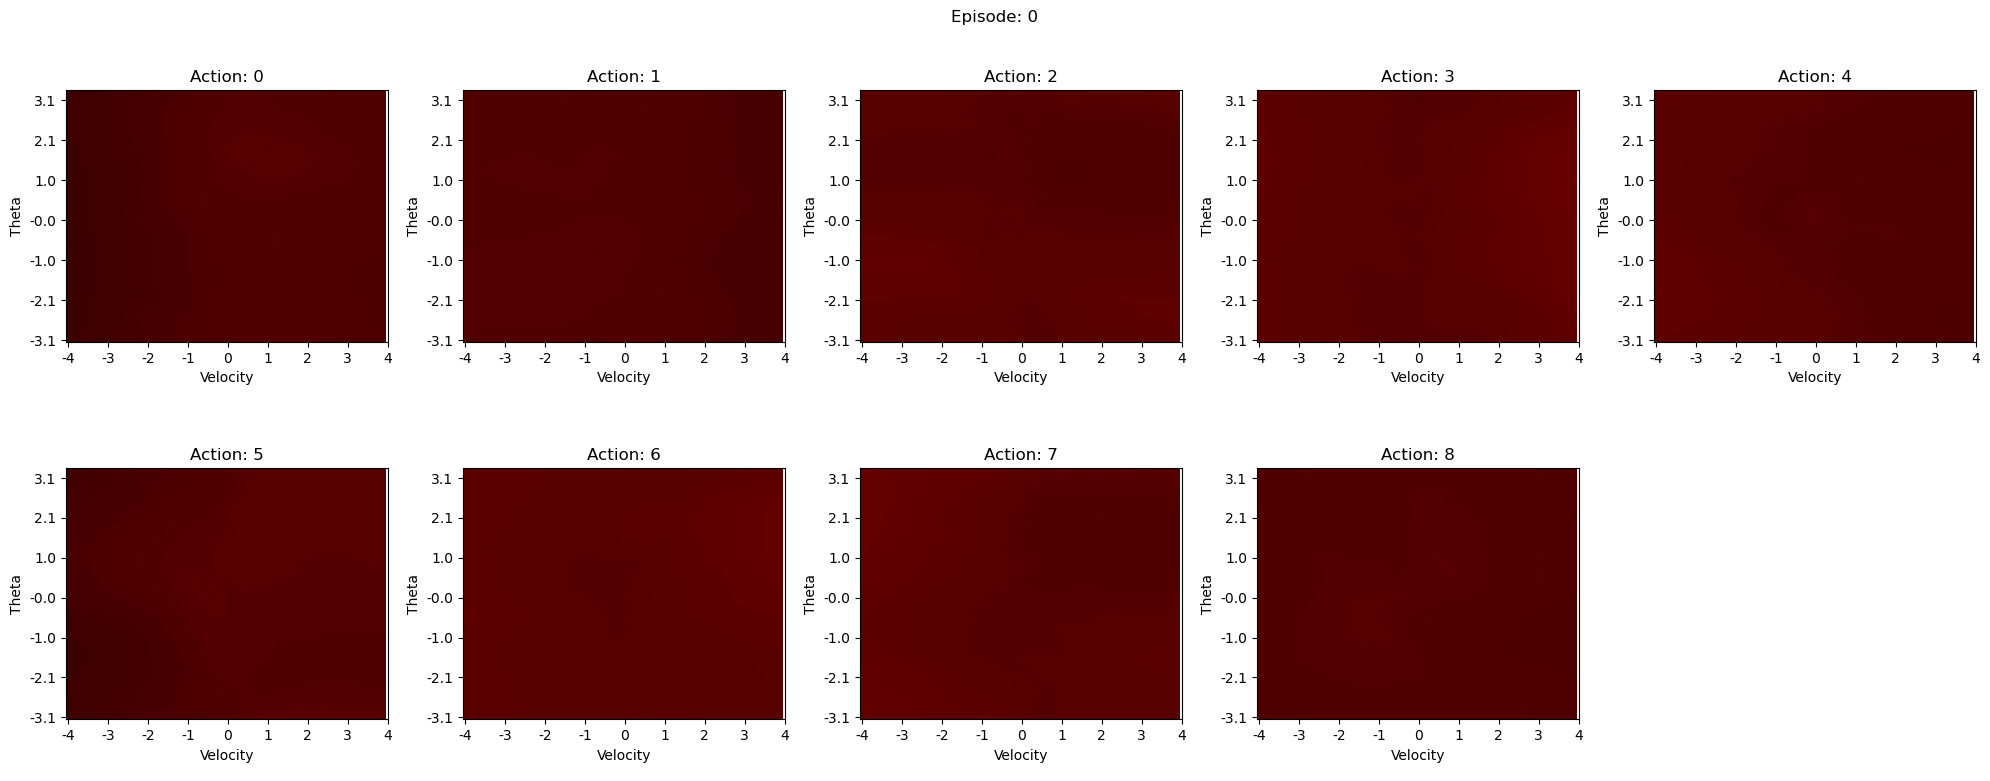

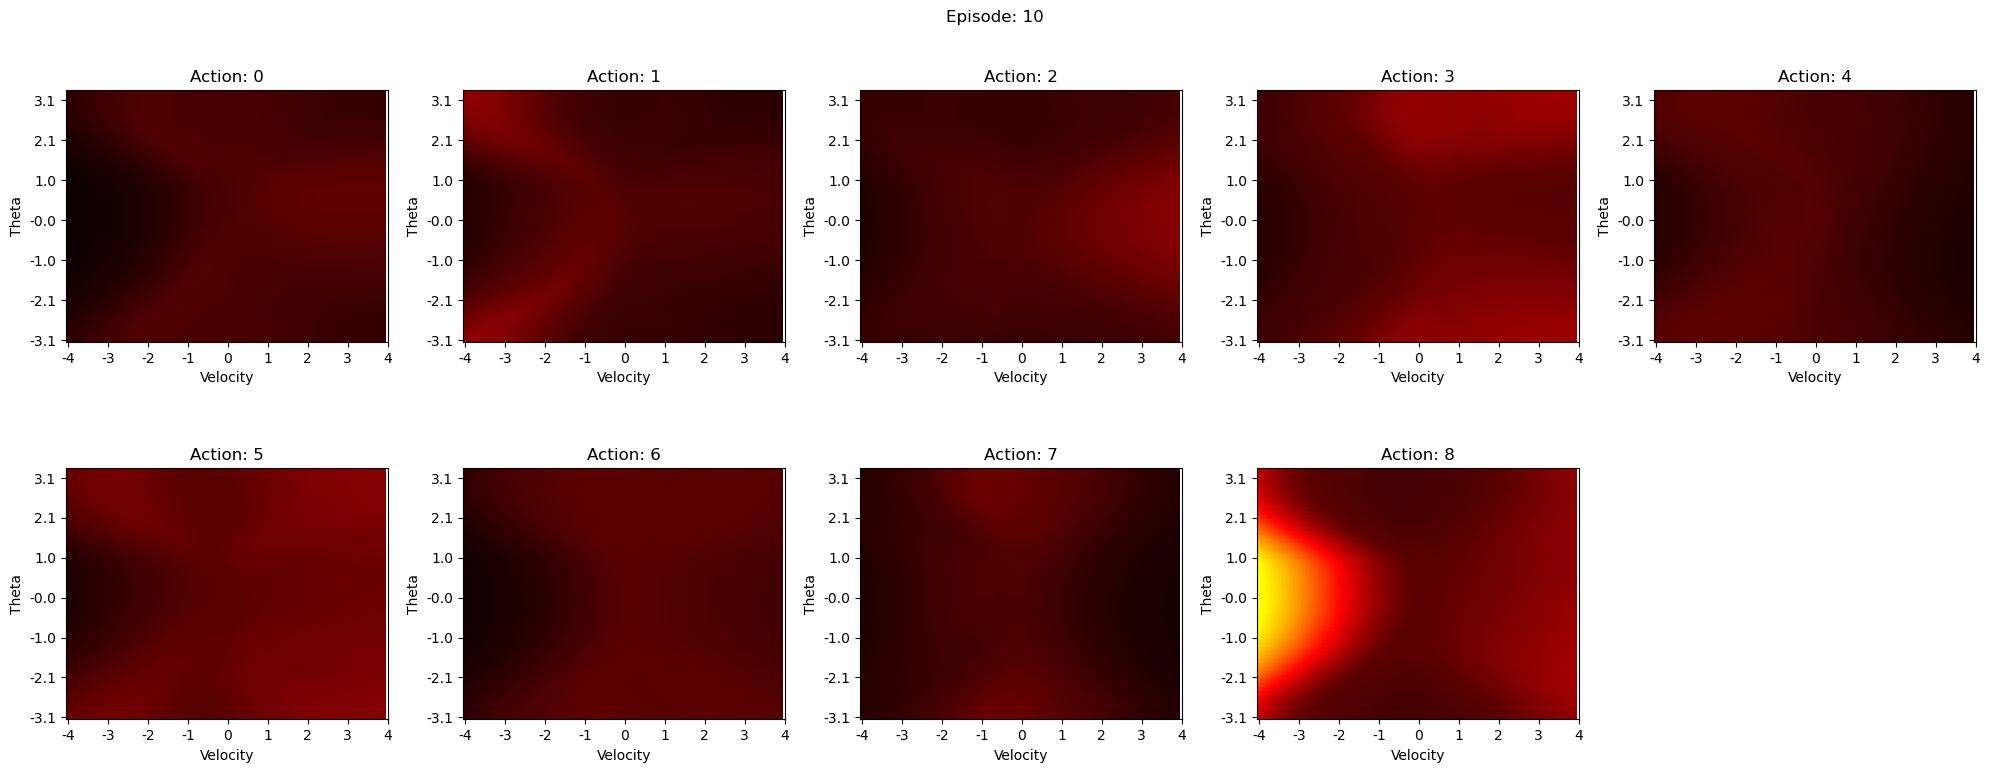

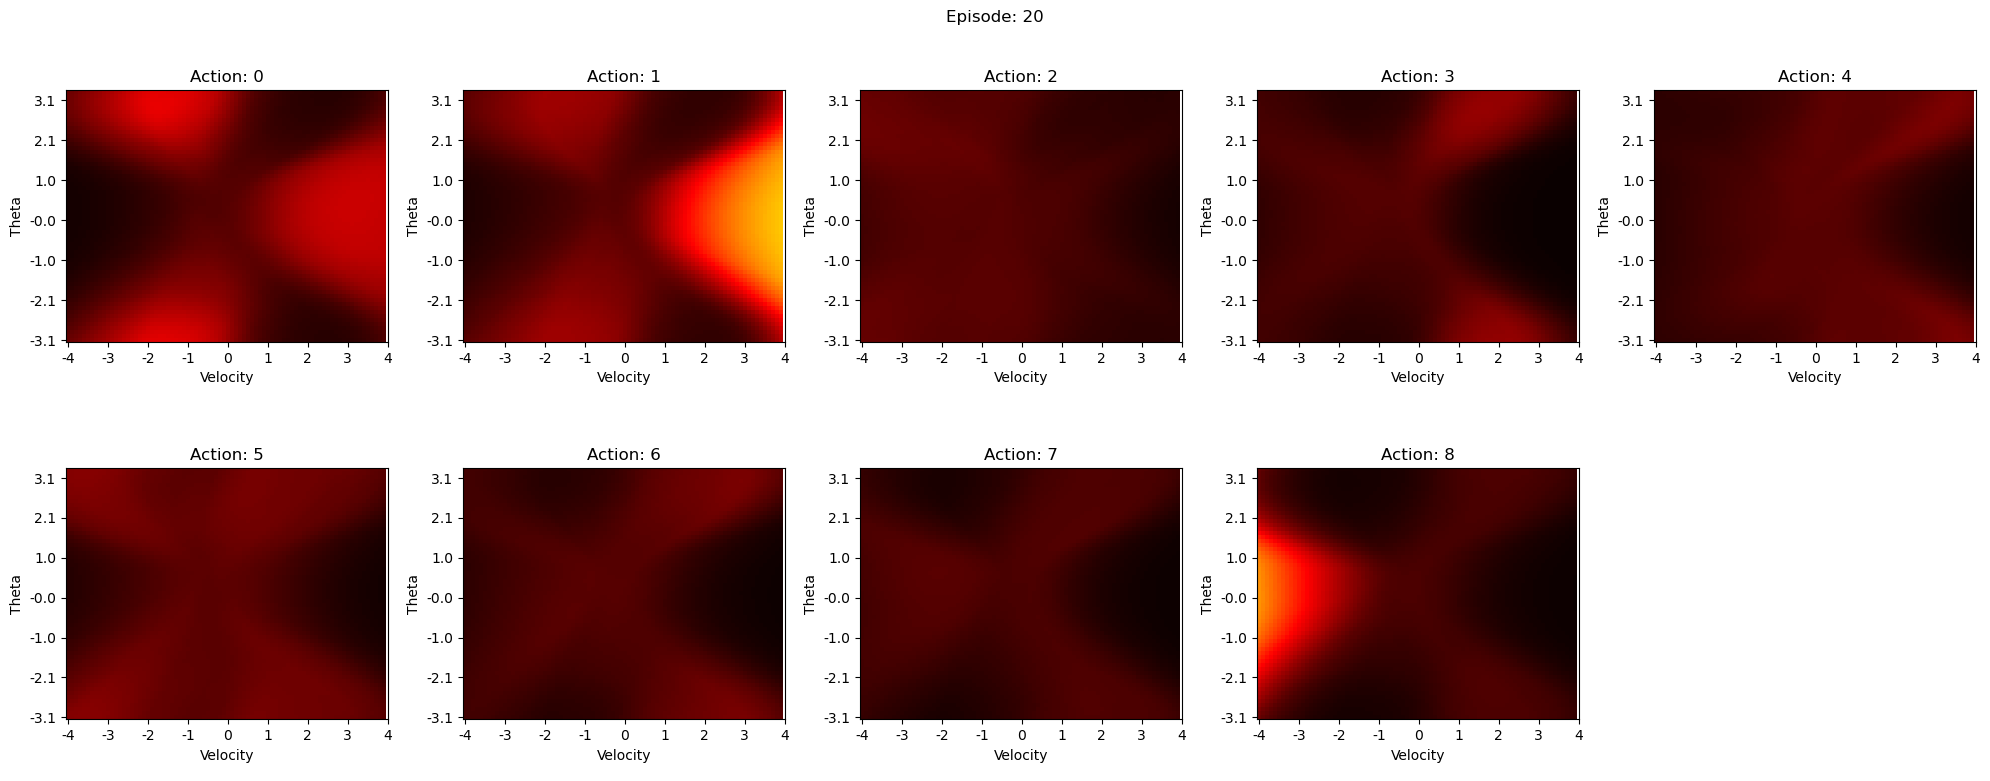

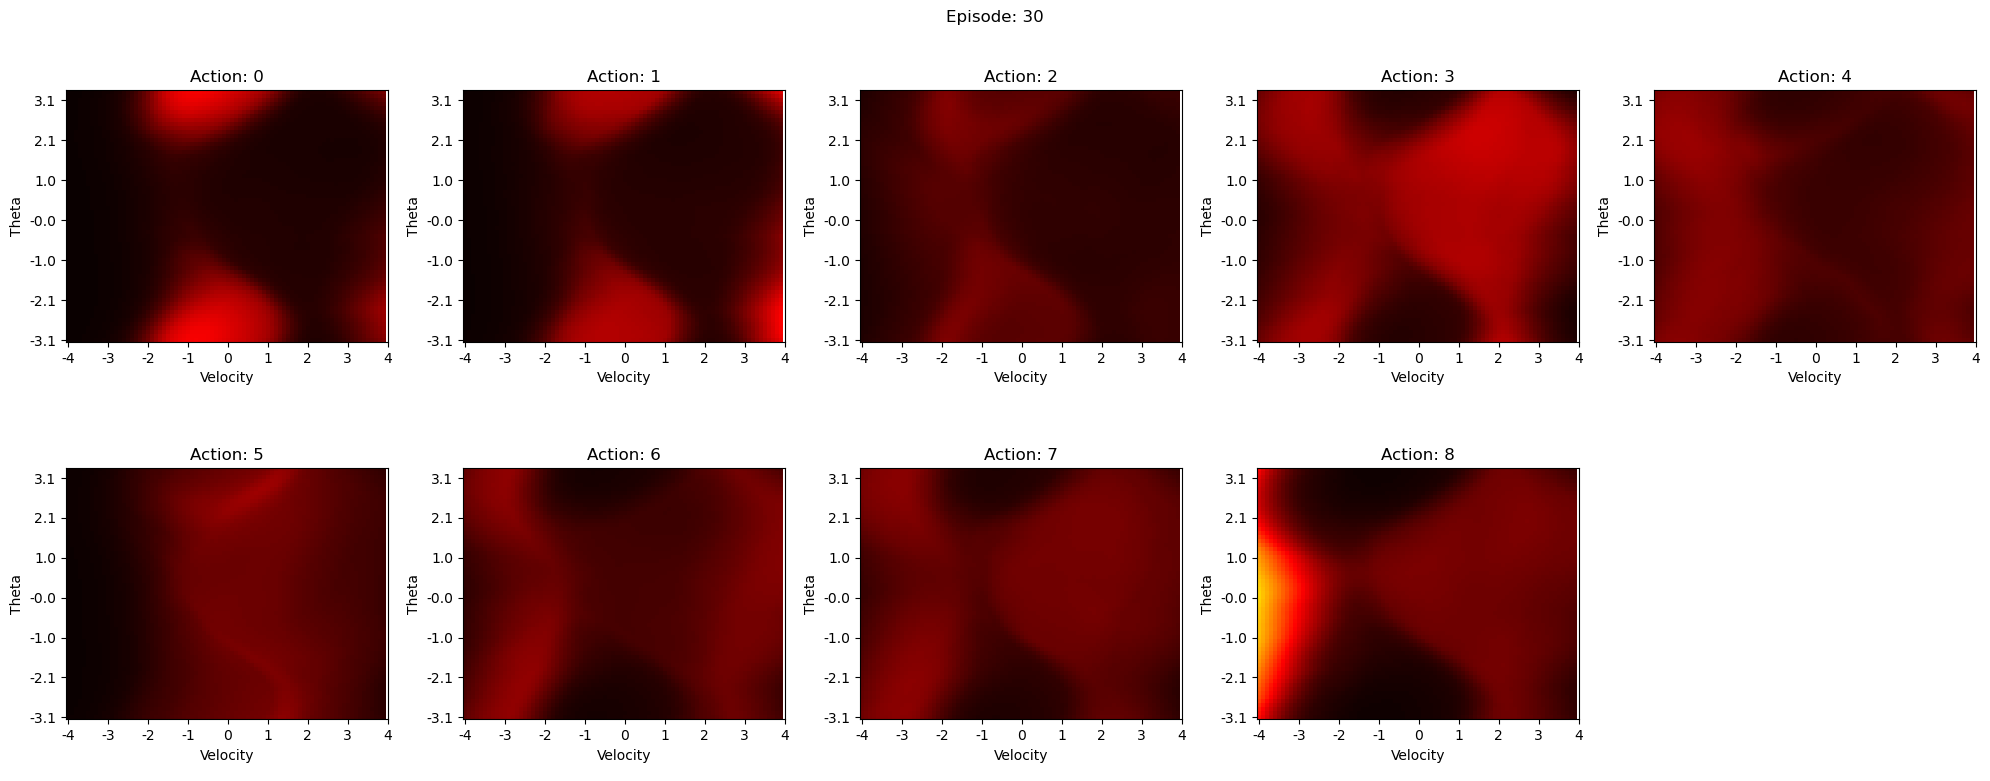

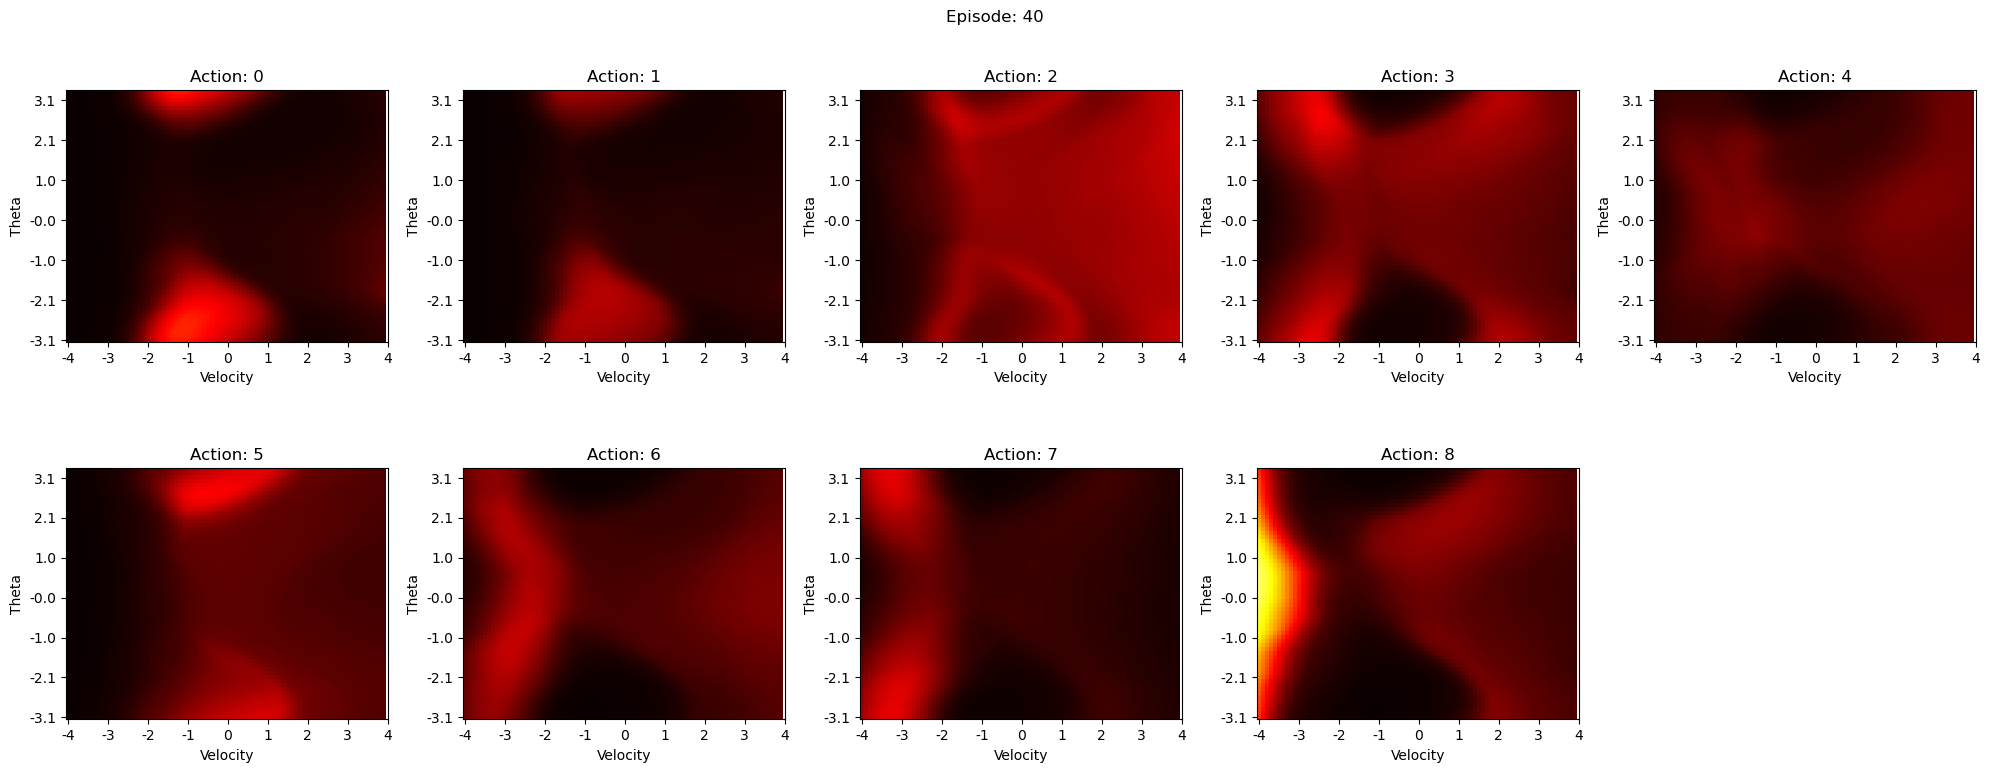

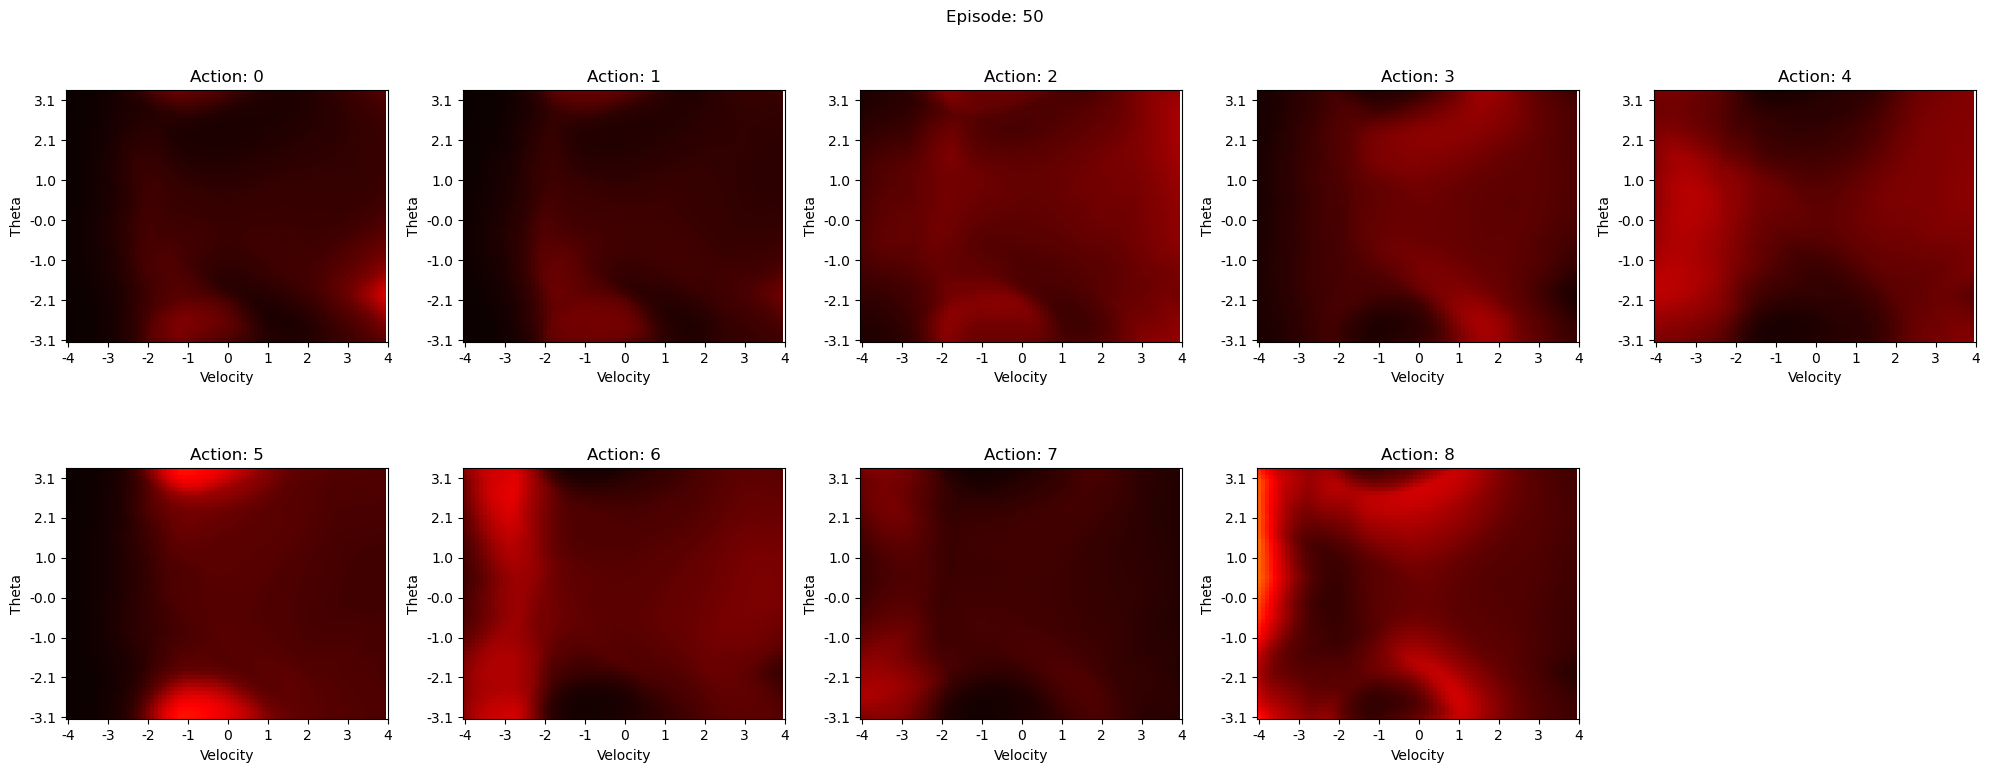

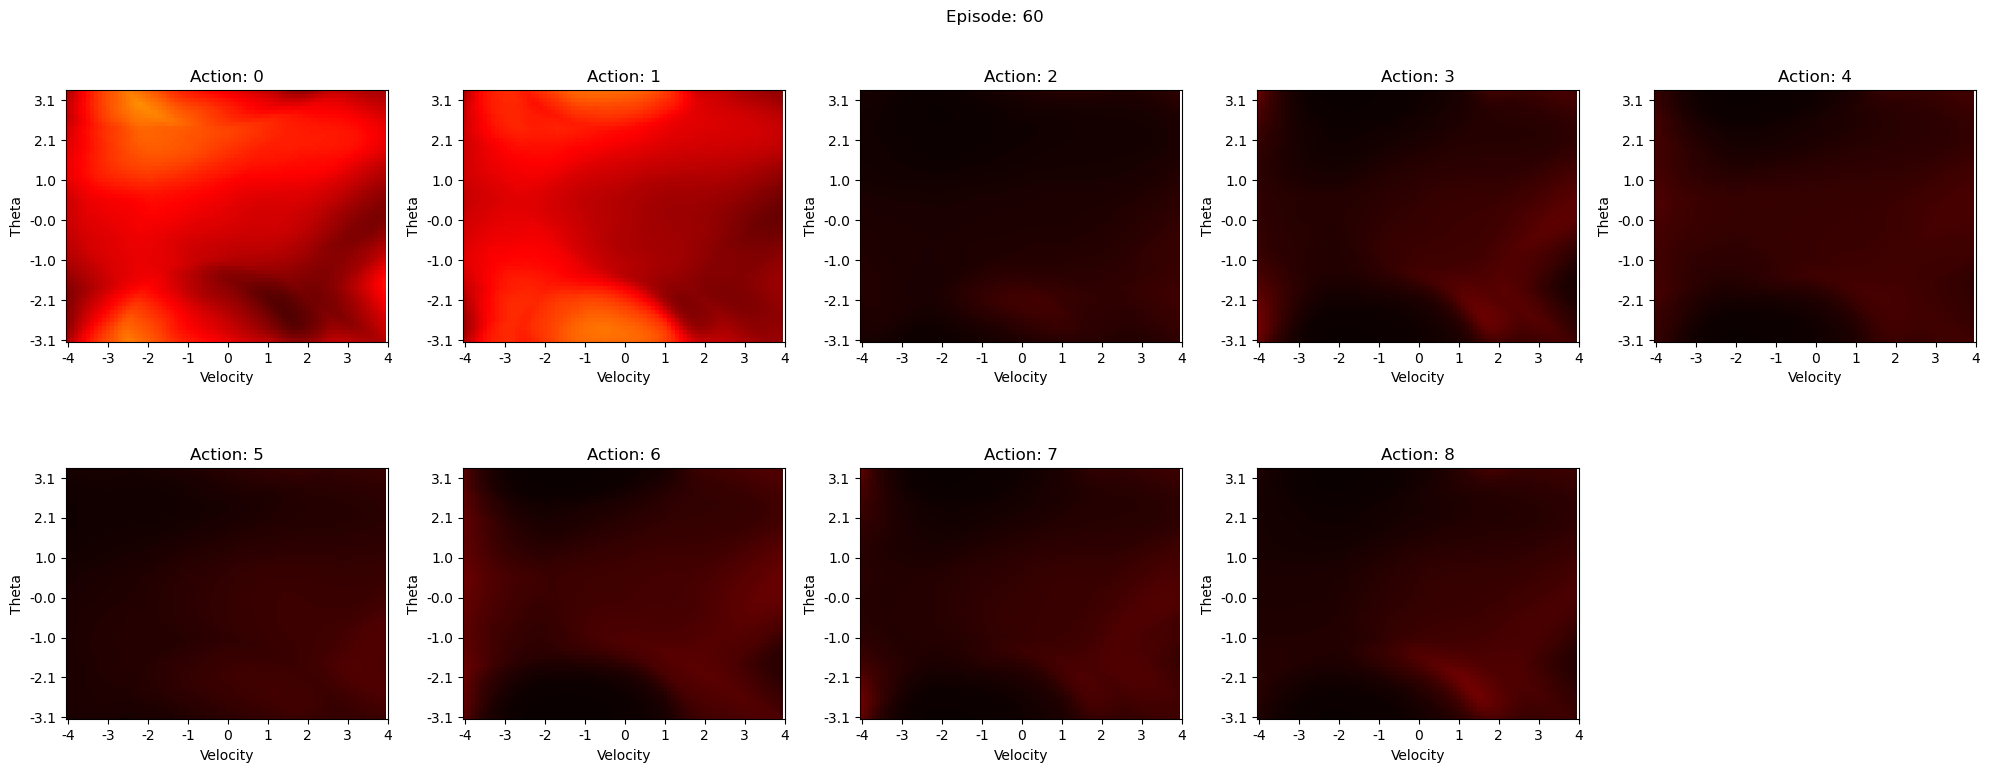

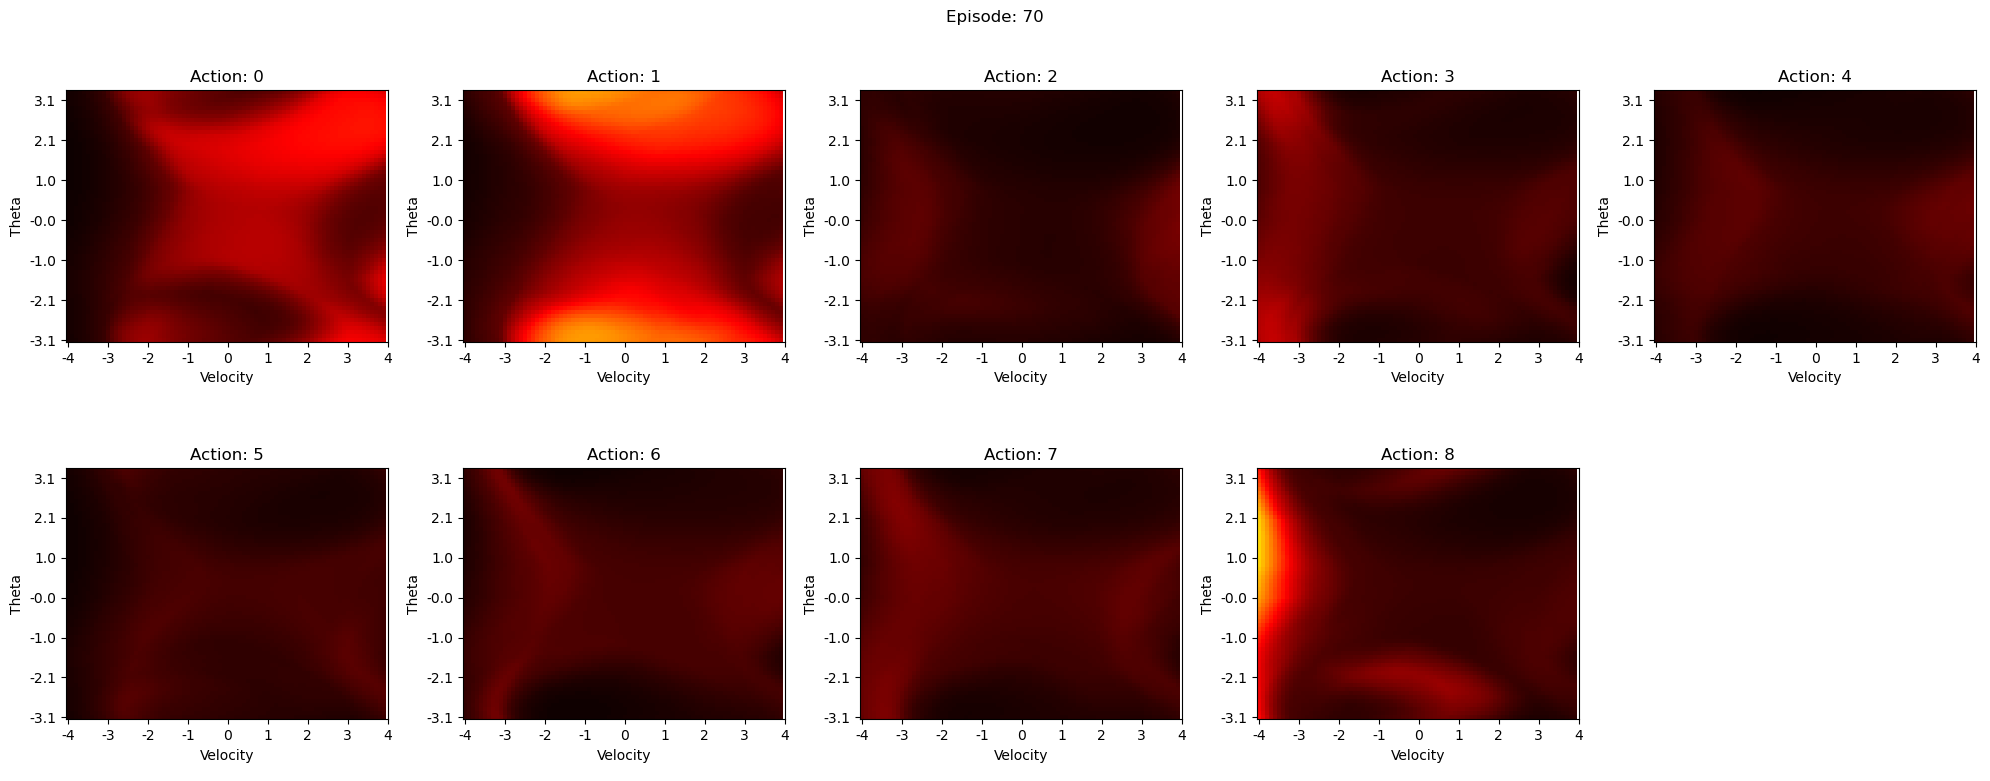

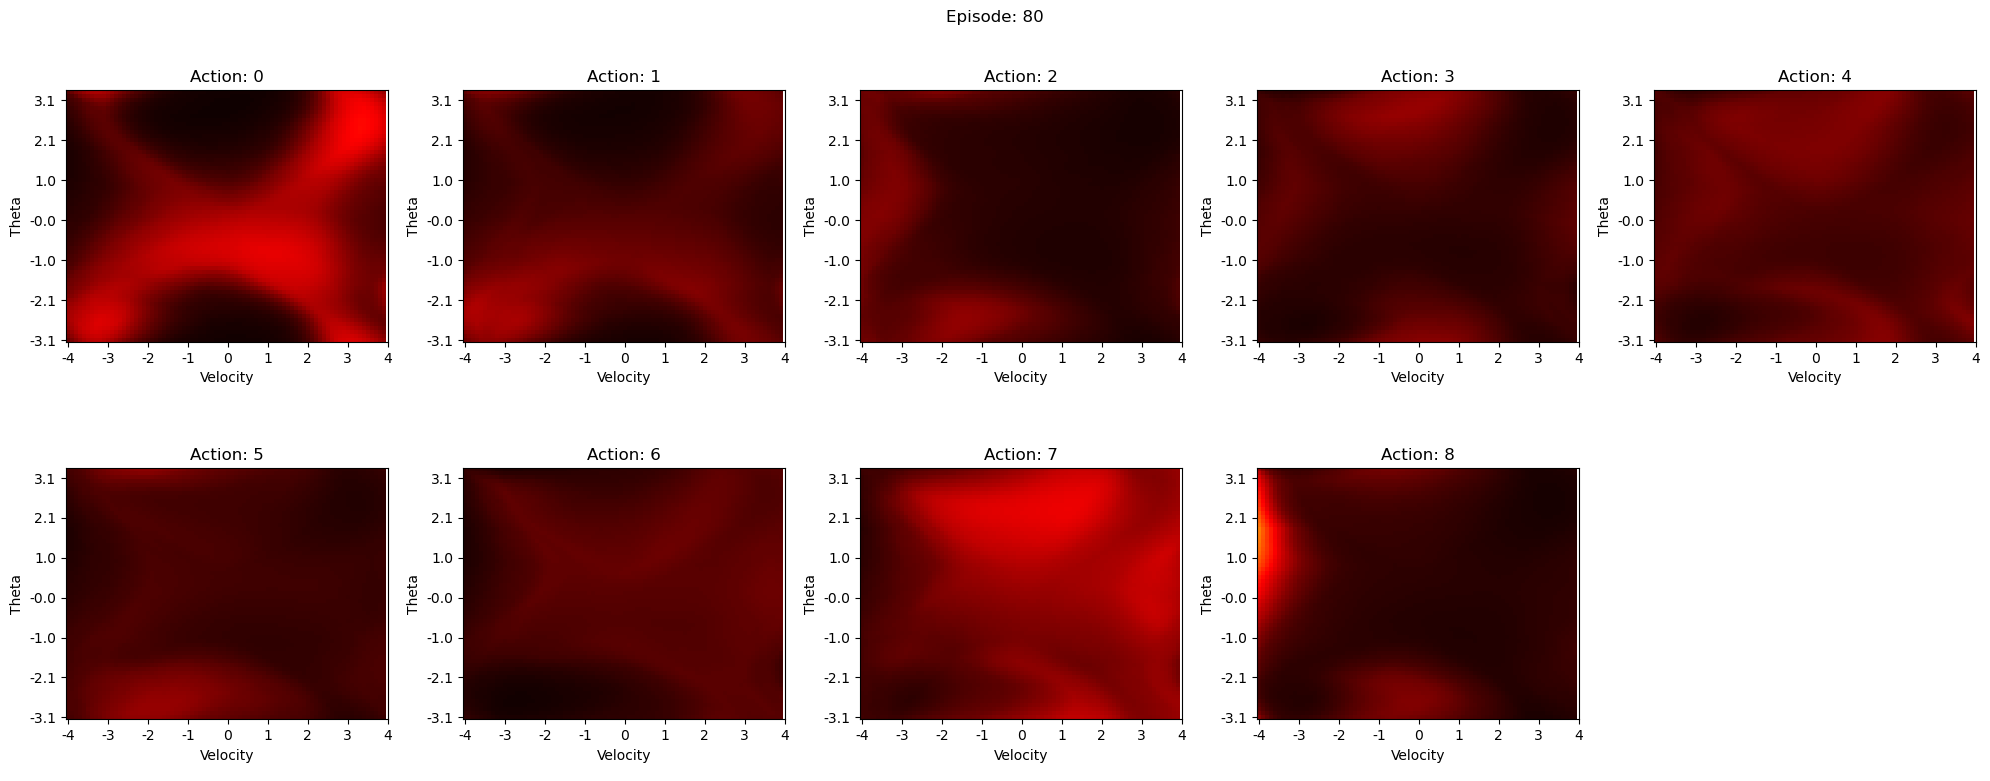

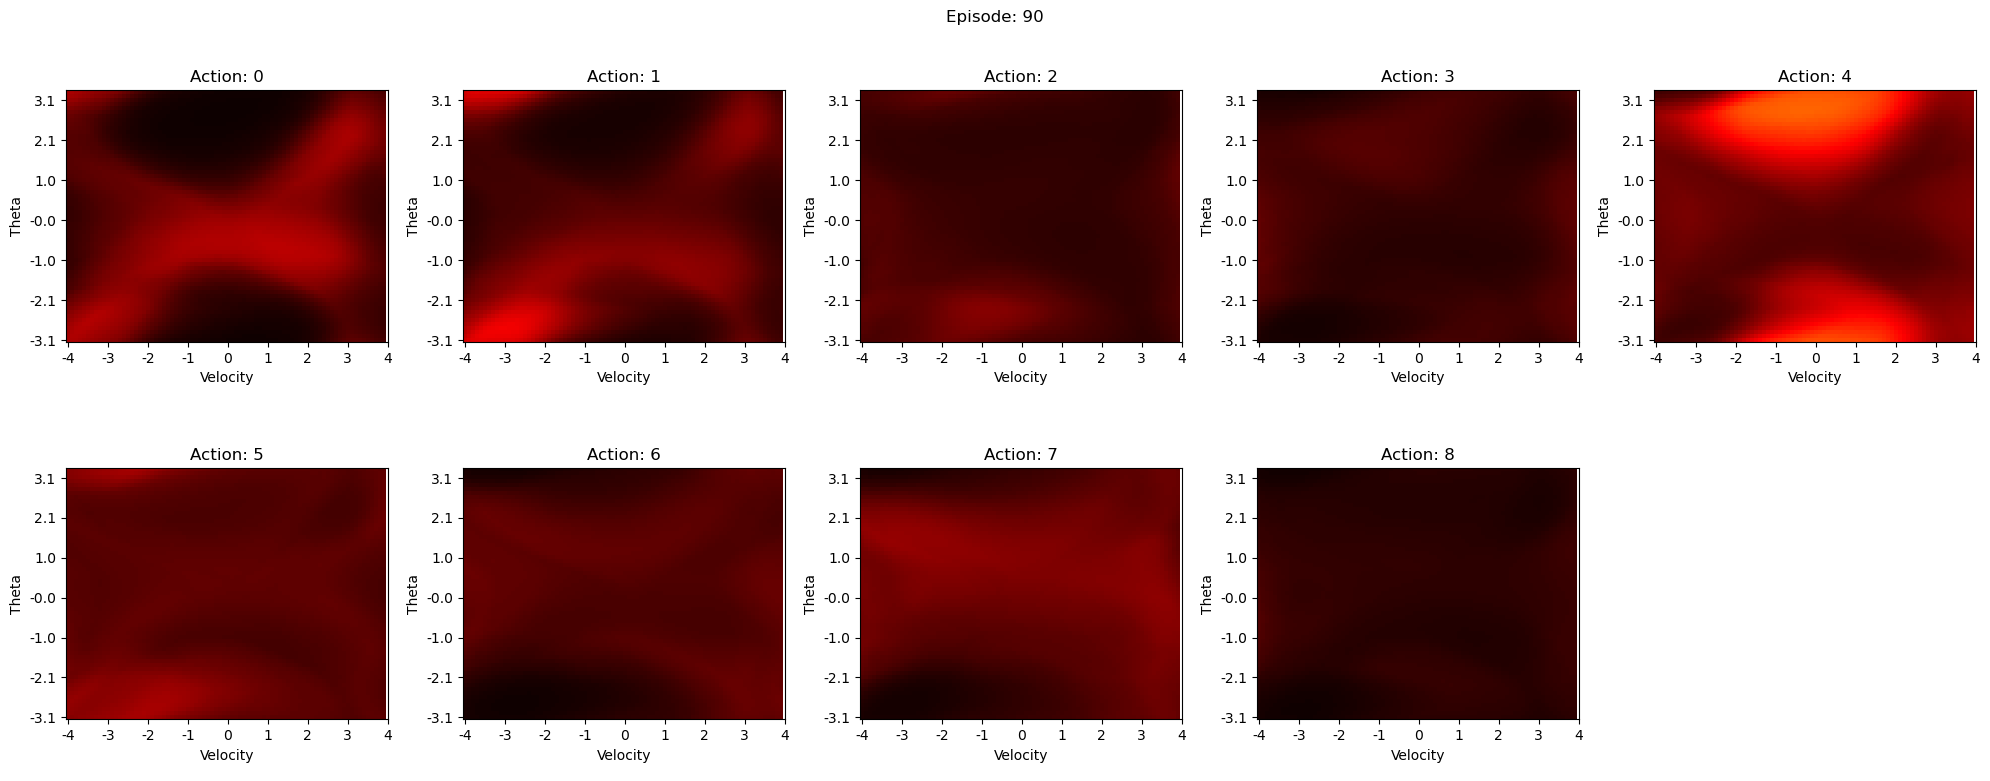

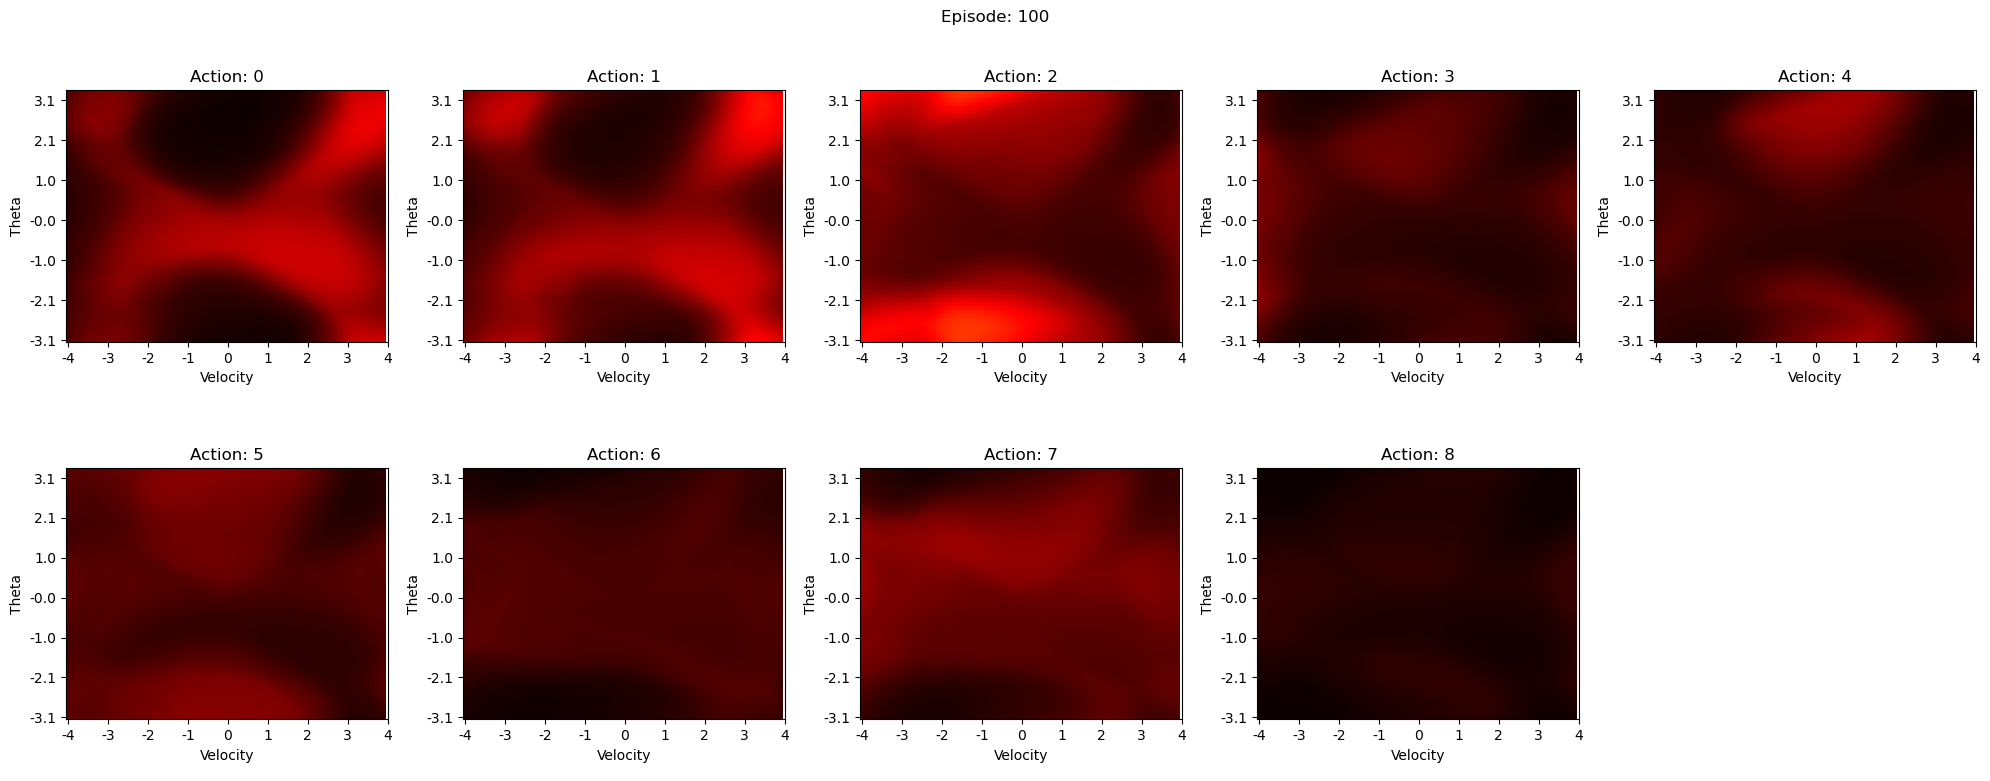

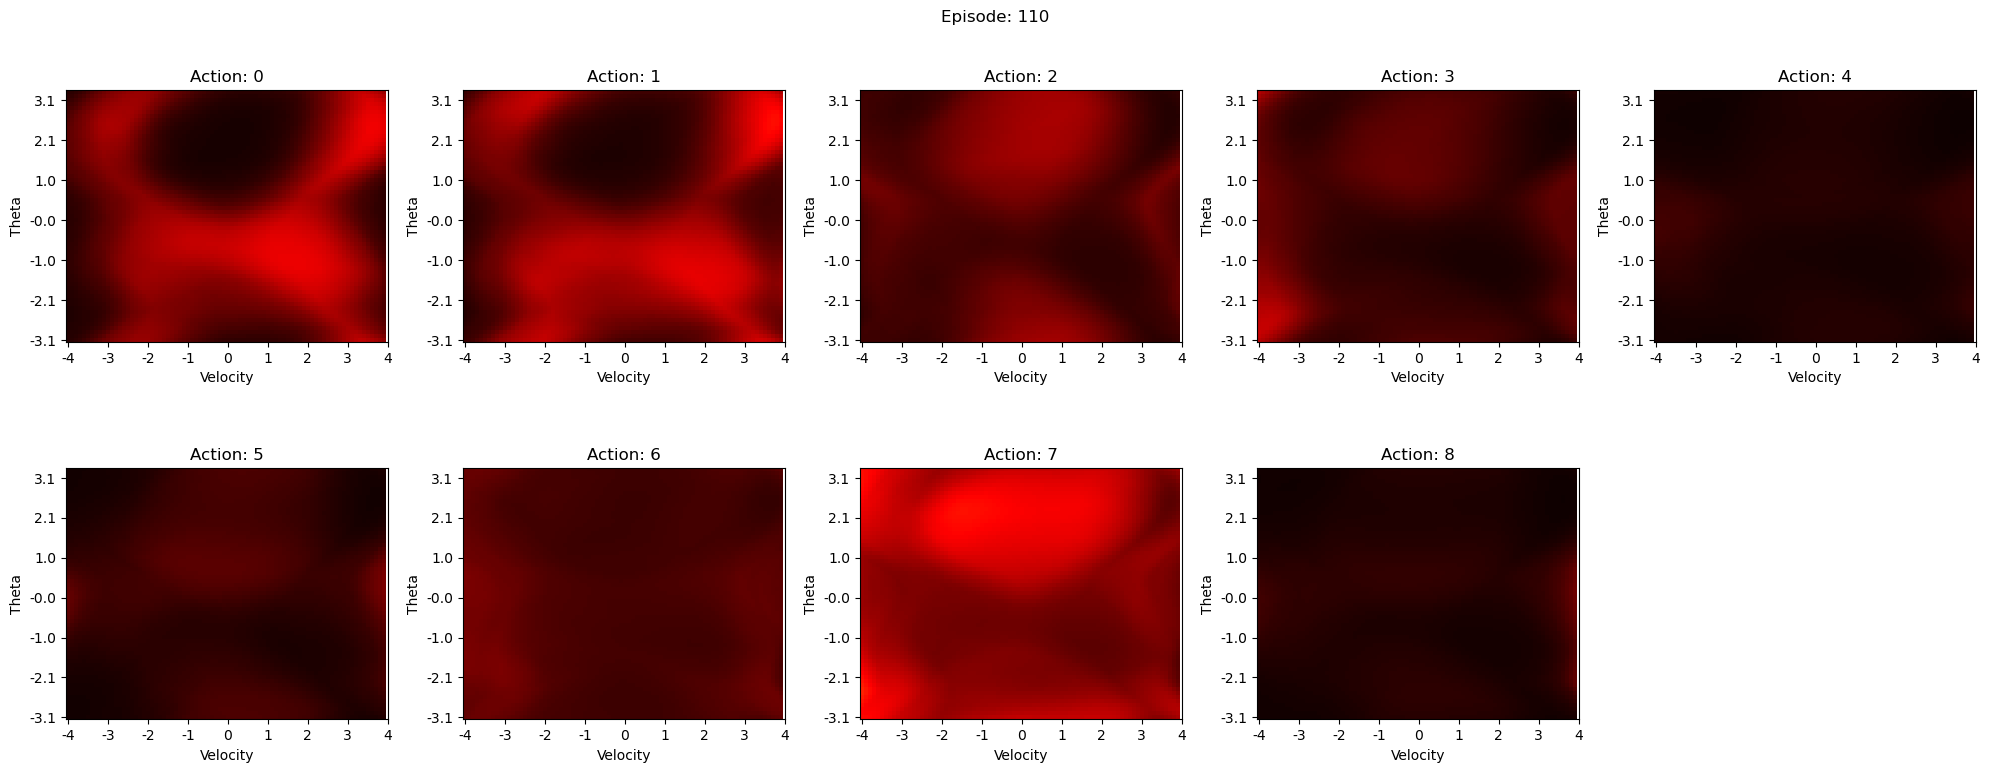

In [26]:
# env = gym.make("Pendulum-v1", g=9.81, render_mode="human")
env = gym.make("Pendulum-v1", g=9.81)

model = DQN(3, 1)


for episode in range(1000):
    state, info = env.reset()
    terminated = False
    truncated = False
    step = 0

    rewards = []
    before_reward = None

    while not terminated and step < 300:

        # 모델로 행동 예측
        action = model.call(np.array([state])).numpy()[0]  # type: ignore
        # if np.random.rand() < 0.01:
        #     action = np.random.choice(9)
        # else:
        #     action = np.argmax(action)
        action = np.random.choice(9, p=action)
        # 행동 실행
        next_state, reward, terminated, truncated, info = env.step((action*4-2,))

        # if state[0] < 0.9 and next_state[0] > 0.9:
        #     reward += 10  # type: ignore
        # elif state[0] > 0.9 and next_state[0] < 0.9:
        #     reward -= 15  # type: ignore


        # 리플레이 버퍼에 기억
        model.remember(state, action, reward, next_state, terminated)
        
        # 모델 업데이트
        update_model(model)

        state = next_state
        step += 1

        rewards.append(reward)

    print("Episode: {}, Steps: {}, Score: {:.2f}, Last Score: {:.2f}".format(episode, step, sum(rewards) / len(rewards), sum(rewards[-10:])/10))

env.close()

In [ ]:
model.save_weights('model2', save_format='tf')